The system is governed by

\begin{equation}
\nabla\cdot \vec{u} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}+\vec{u}\cdot\nabla\vec{u} = -\nabla p + \frac{Pr}{Pe}\nabla^2\vec{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\vec{u}\cdot\nabla T - w = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\vec{u}\cdot\nabla S - R_\rho w = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

2024-08-09 10:54:36,612 subsystems 0/1 INFO :: Building subproblem matrices 1/1024 (~0%) Elapsed: 0s, Remaining: 41s, Rate: 2.5e+01/s
2024-08-09 10:54:41,142 subsystems 0/1 INFO :: Building subproblem matrices 103/1024 (~10%) Elapsed: 5s, Remaining: 41s, Rate: 2.3e+01/s
2024-08-09 10:54:45,339 subsystems 0/1 INFO :: Building subproblem matrices 206/1024 (~20%) Elapsed: 9s, Remaining: 35s, Rate: 2.3e+01/s
2024-08-09 10:54:46,582 subsystems 0/1 INFO :: Building subproblem matrices 232/1024 (~23%) Elapsed: 10s, Remaining: 34s, Rate: 2.3e+01/s
2024-08-09 10:54:49,407 subsystems 0/1 INFO :: Building subproblem matrices 309/1024 (~30%) Elapsed: 13s, Remaining: 30s, Rate: 2.4e+01/s
2024-08-09 10:54:53,507 subsystems 0/1 INFO :: Building subproblem matrices 412/1024 (~40%) Elapsed: 17s, Remaining: 25s, Rate: 2.4e+01/s
2024-08-09 10:54:56,595 subsystems 0/1 INFO :: Building subproblem matrices 488/1024 (~48%) Elapsed: 20s, Remaining: 22s, Rate: 2.4e+01/s
2024-08-09 10:54:57,867 subsystems 0/1 I

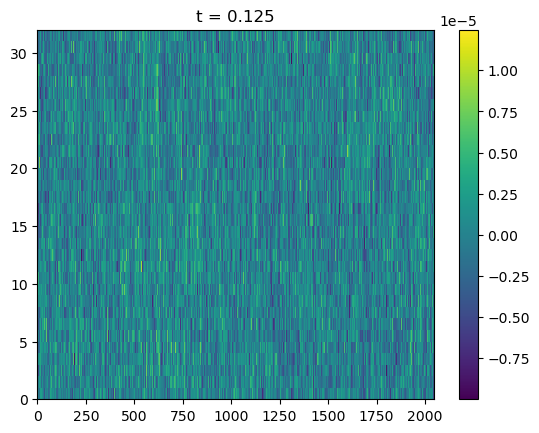

Completed iteration 101, time=12.625


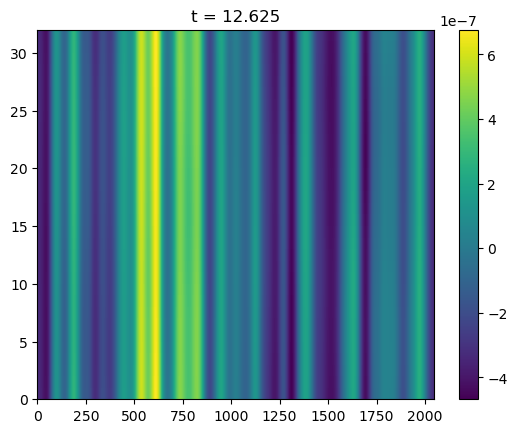

Completed iteration 201, time=25.125


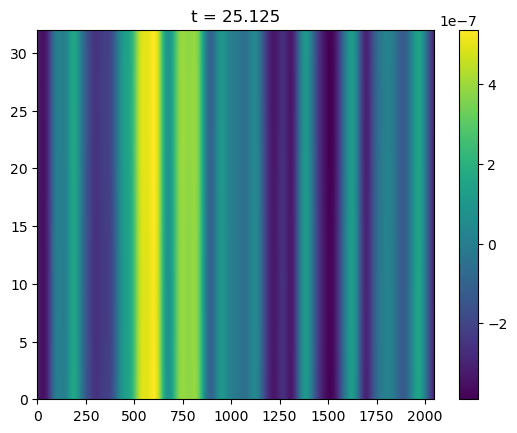

Completed iteration 301, time=37.625


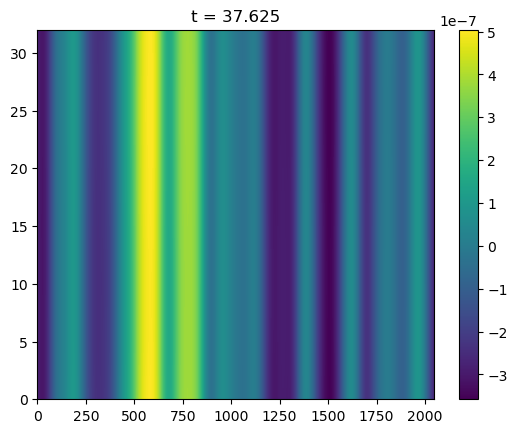

Completed iteration 401, time=50.125


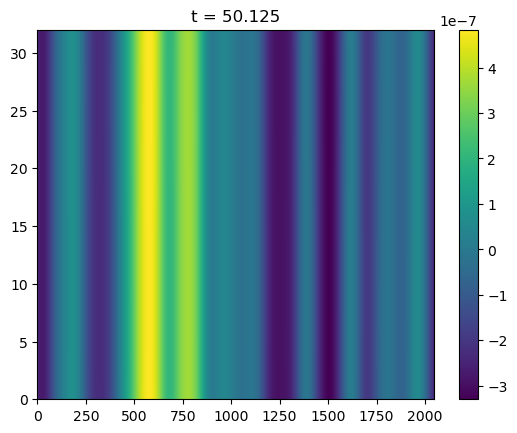

Completed iteration 501, time=62.625


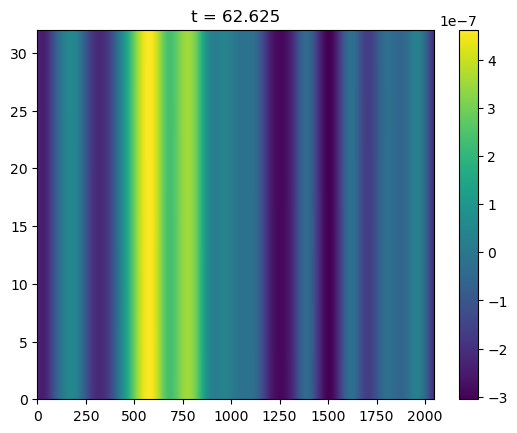

Completed iteration 601, time=75.125


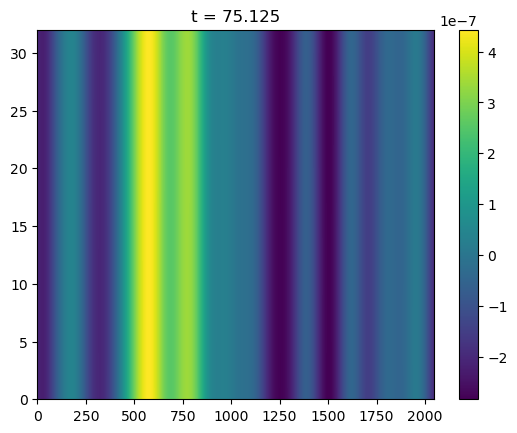

Completed iteration 701, time=87.625


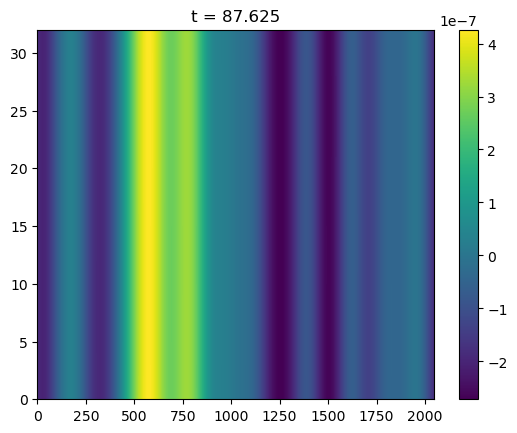

Completed iteration 801, time=100.125


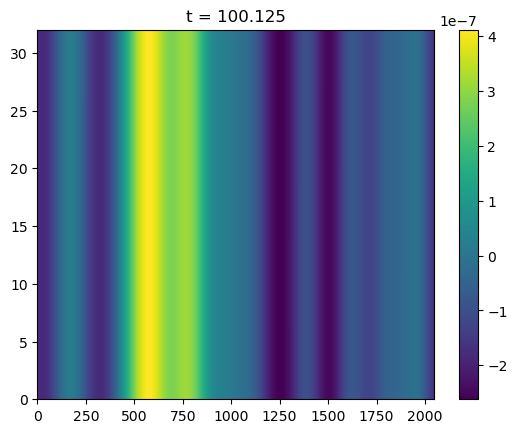

Completed iteration 901, time=112.625


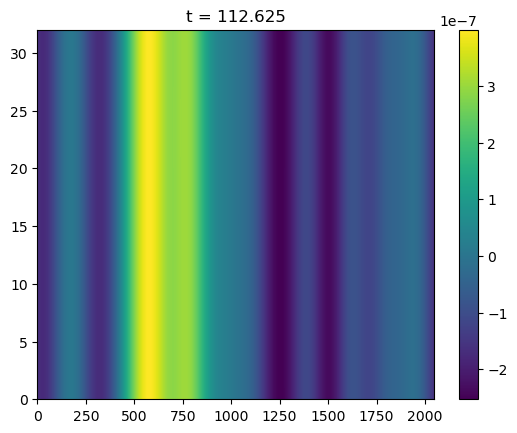

Completed iteration 1001, time=125.125


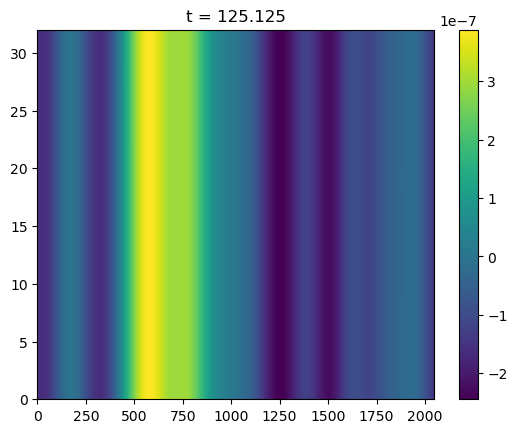

Completed iteration 1101, time=137.625


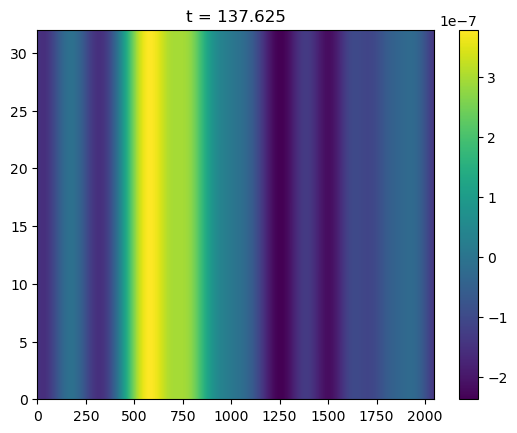

Completed iteration 1201, time=150.125


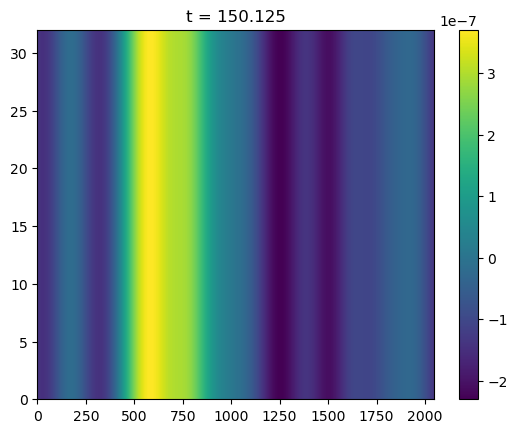

Completed iteration 1301, time=162.625


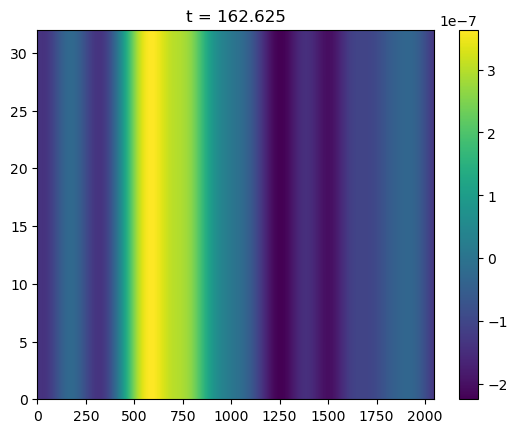

Completed iteration 1401, time=175.125


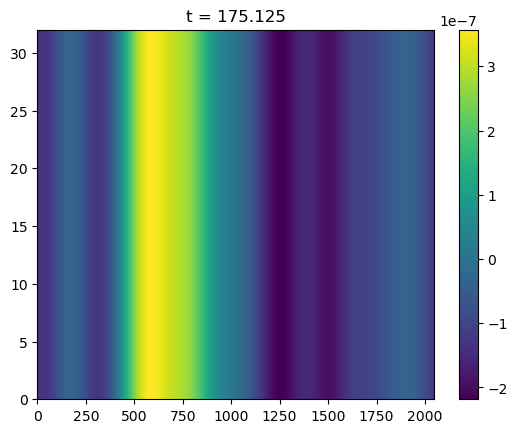

Completed iteration 1501, time=187.625


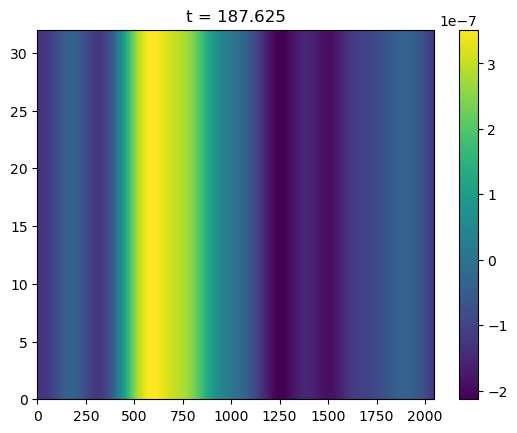

2024-08-09 11:03:06,374 solvers 0/1 INFO :: Simulation stop time reached.


In [8]:
# This code performs two-dimensional DNS using Dedalus3 based on governing equations in Radko's paper 
# [Thermohaline layering in dynamically and diffusively stable shear flows]
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

dealias = 1           # scaling factor
pi = np.pi

Ri = 10. # Richardson number [= 1 for figure 3]
Rp = 2.   # density ratio
Pe = 1e2 # Peclet number
Pr = 10.  # Prandtl number
tau = 0.01 # diffusivity ratio

Lx, Lz = 64., 1.
Nx, Nz = 2048, 32
# Nx, Nz = 256, 128
# Nx, Nz = 768, 384

# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)
# define fields
p = dist.Field(name='p', bases=(xbasis,zbasis)) # pressure
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis)) # velocity
sa = dist.Field(name='sa', bases=(xbasis,zbasis)) # salinity
te = dist.Field(name='te', bases=(xbasis,zbasis)) # temperature
# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define vertical velocity component
w = u @ ez

# create constant sub-field for incompressible flow condition's equation
tau_p = dist.Field(name='tau_p') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

grad_te = d3.grad(te) # First-order reduction
grad_sa = d3.grad(sa) # First-order reduction
grad_u = d3.grad(u) # First-order reduction
# First-order form: "lap(f)" becomes "div(grad_f)"
lap_u = d3.div(grad_u)
lap_te = d3.div(grad_te)
lap_sa = d3.div(grad_sa)
# First-order form: "div(A)" becomes "trace(grad_A)"

# Problem
problem = d3.IVP([p, tau_p, u, te, sa], namespace=locals())

# add equations
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge
problem.add_equation("dt(u) + grad(p) - (Pr/Pe)*lap_u - (4*pi*pi*Ri/(Rp-1))*(te-sa)*ez = - u@grad(u)")
problem.add_equation("dt(te) - (1./Pe)*lap_te - w = - u@grad(te)")
problem.add_equation("dt(sa) - (tau/Pe)*lap_sa - Rp*w = - u@grad(sa)")

stop_sim_time = 200 # Stopping criteria
# timestepper = d3.RK443 # 3rd-order 4-stage DIRK+ERK scheme [Ascher 1997 sec 2.8] https://doi-org.ezproxy.lib.uconn.edu/10.1016/S0168-9274(97)00056-1
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# define initial condition
p.fill_random('g', seed=42, distribution='normal', scale=1e-5) # Random noise
# p['g'] -= -4*pi*pi*Pr/Pe*np.sin(2*pi*z)
u.fill_random('g', seed=42, distribution='normal', scale=1e-5) # Random noise
# u['g'][0] -= np.sin(2*pi*z)
te.fill_random('g', seed=42, distribution='normal', scale=1e-5) # Random noise
# te['g'] -= np.sin(1*pi*x+pi/2)
sa.fill_random('g', seed=42, distribution='normal', scale=1e-5) # Random noise
# sa['g'] -= np.sin(1*pi*x+pi/2)

max_timestep = 0.125
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Main loop
print('Starting main loop')
while solver.proceed:
    timestep = CFL.compute_timestep()
    solver.step(timestep)
    if (solver.iteration-1) % 100 == 0:
        print('Completed iteration {}, time={:.3f}'.format(solver.iteration, solver.sim_time))
        temp = np.copy(te['g'])
        te_plot = plt.pcolormesh(temp.transpose())
        plt.colorbar(te_plot) 
        plt.title("t = {:.3f}".format(solver.sim_time))
        plt.show()